In [123]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Официальный ноутбук: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb

Загрузим исходные данные

In [71]:
# url - https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
data_dir = './RNN models and data  for chapter 6/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
data = pd.read_csv(fname)

In [72]:
print('Размерность датафрейма:',data.shape)

Размерность датафрейма: (420551, 15)


In [73]:
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [80]:
data['Date Time'] = pd.to_datetime(data['Date Time'])
data.set_index('Date Time', inplace = True)

In [81]:
data.dtypes

p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

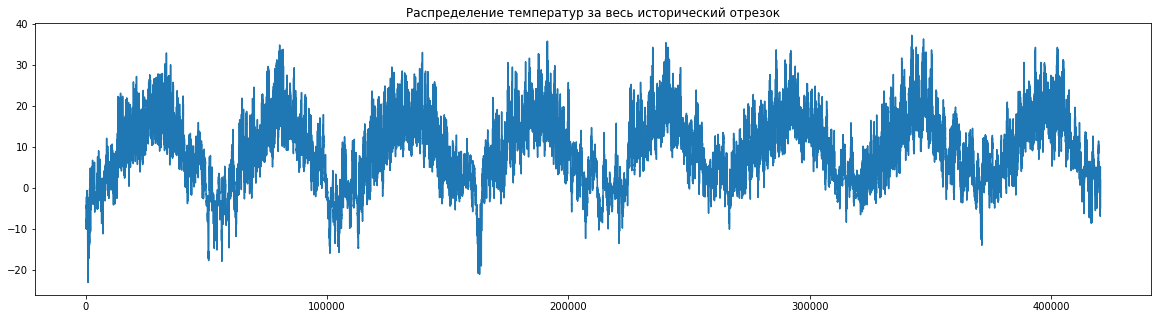

In [82]:
plt.figure(figsize = (20, 5))
plt.plot(range(len(data)), data['T (degC)'].values)
plt.title('Распределение температур за весь исторический отрезок')
plt.show()

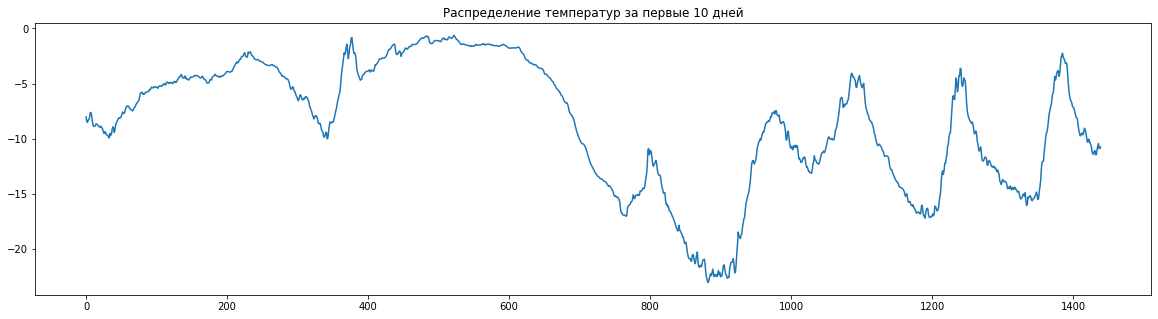

In [83]:
plt.figure(figsize = (20, 5))
plt.plot(range(1440), data['T (degC)'][:1440].values)
plt.title('Распределение температур за первые 10 дней')
plt.show()

Сформулируем задачу: <br>
По lookback интервалам (интервал равен 10 минутам) за прошлый период, за который отобраны образцы через каждые step интервалов, предсказать температуру на следующие delay интервалов.

In [84]:
lookback = 720 #5 дней
step = 6 # Один образец в чаас
delay = 144 # 24 часа в будущем

Для обучения мы будем использовать только первые 200000 замеров

In [85]:
# Нормализация данных
mean = data[:200000].mean(axis = 0)
data -= mean
std = data[:200000].std(axis = 0)
data /= std

In [86]:
data.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,0.900145,-1.931354,-1.982105,-1.862796,1.072850,-1.307418,-1.473754,-0.798684,-1.476264,-1.478152,2.123745,-0.729503,-0.780678,-0.276135
2009-01-01 00:20:00,0.906041,-1.975409,-2.025665,-1.915825,1.078828,-1.320424,-1.495192,-0.800750,-1.495021,-1.499318,2.171993,-0.931238,-0.887943,-0.463173
2009-01-01 00:30:00,0.901324,-1.986705,-2.036834,-1.920011,1.108719,-1.323025,-1.497574,-0.802816,-1.498772,-1.501669,2.182349,-1.276140,-1.261224,-0.053306


Подготовим необходимые генераторы данных

In [102]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    '''
    Функция-генератор, возвращающая временные последовательности образцов и их целей
    data - исходный массив данных
    lookback - количество интервалов в прошлом от заданного момента, за которое отбираются данные
    delay - количество интервалов в будущем от заданного момента, за которое отбираютс целевые данные
    min_index, max_index - индексы, ограничивающие область для извлечения данных
    shuffle - флаг, определяющий порядок извлечения образцов
    batch_size - количество образцов в пакете
    sep - период в интервалах, за который извлекается один образец    
    '''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [104]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(data.values, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle = True,
                     step=step, batch_size=batch_size) #Почему shuffle = True???
val_gen = generator(data.values, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
                     step=step, batch_size=batch_size)
test_gen = generator(data.values, lookback=lookback, delay=delay, min_index=300001, max_index=None,
                     step=step, batch_size=batch_size)

In [105]:
val_steps = (300000 - 200001 - lookback) // batch_size #Cколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных  целиком
test_steps = (len(data) - 300001 - lookback) // batch_size #Cколько раз нужно обратиться к test_gen, чтобы получить контрольный набор данных целиком 

**Базовое решение без привлечения машинного обучения**

Наивная гипотеза - темепературы в следующие 24 часа будут постоянны и равны текущей температуре.

In [112]:
def evaluate_naive_method():
    '''
    Функция возвращает MAE оценку наивного алгоритма
    '''
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return(np.mean(batch_maes))

In [113]:
naive_approach_mae = evaluate_naive_method()
print(naive_approach_mae)

0.2897352486497107


In [120]:
print('Средняя абсолютная ошибка температуры: {:.3f} degC'.format(naive_approach_mae * std[1]))

Средняя абсолютная ошибка температуры: 2.565 degC


**Базовое решение с привлечнием машинного обучения**

Построим базовое решение с помощью двухслойной полносвязной модели

In [125]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                             steps_per_epoch = 500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps = val_steps)

W0908 16:31:02.198641 140556792346432 deprecation_wrapper.py:119] From /home/grigoriy/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 16:31:02.516108 140556792346432 deprecation_wrapper.py:119] From /home/grigoriy/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0908 16:31:02.526831 140556792346432 deprecation_wrapper.py:119] From /home/grigoriy/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 25s 51ms/step - loss: 1.2461 - val_loss: 0.7135
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.4292 - val_loss: 0.3209
Epoch 3/20
500/500 [==============================] - 21s 43ms/step - loss: 0.3269 - val_loss: 0.3082
Epoch 4/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2892 - val_loss: 0.3189
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2670 - val_loss: 0.3138
Epoch 6/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2587 - val_loss: 0.3085
Epoch 7/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2596 - val_loss: 0.3084
Epoch 8/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2431 - val_loss: 0.3511
Epoch 9/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2624 - val_loss: 0.4046
Epoch 10/20
500/500 [==============================] - 22s 43ms/step - loss: 0.243

In [130]:
model.save('./RNN models and data  for chapter 6/Simple_RNN_model.h5')

In [132]:
def plot_results():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
    plt.legend()
    plt.show()   

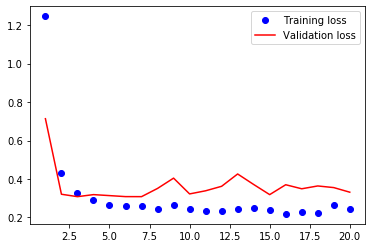

In [133]:
plot_results()

**Первое базовое рекуррентное решение**

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, data.shape[-1]))) #https://keras.io/layers/recurrent/
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, 
                             steps_per_epoch = 500,
                             epochs = 20,
                             validation_data = val_gen,
                             validation_steps = val_steps)

W0908 16:53:48.779156 140556792346432 deprecation.py:323] From /home/grigoriy/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 0.3038

In [ ]:
plot_results()